# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 20)

Populating the interactive namespace from numpy and matplotlib


This image is: <class 'numpy.ndarray'> with dimesions in pixels: (540, 960, 3)


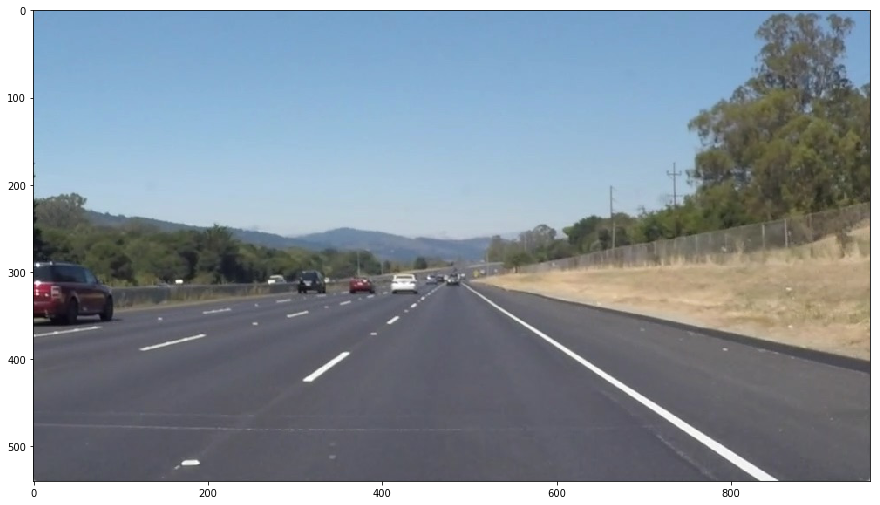

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions in pixels:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math
import numpy.ma as ma

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    # to work with png
    slice1Copy = np.uint8(img)
    return cv2.Canny(slice1Copy, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, alllines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    # create a local copy
    lines = alllines
    
    # array for lines 
    right_lines = np.zeros_like(lines)
    left_lines = np.zeros_like(lines)

    # we look thru all lines and based on negative or positive angle, assign it to left or right bucket
    for line in lines:
        for x1,y1,x2,y2 in line:
            # we check only 0.5 to 0.9 to filter out eronous lines
            if 0.5 <= ((y2-y1)/(x2-x1)) <=0.9:
                right_lines = np.append(right_lines, [line], axis=0)
            elif -0.9 <= ((y2-y1)/(x2-x1)) <= -0.5:
                left_lines = np.append(left_lines, [line], axis=0)
    
    # remove the zeros. Maybe theres a better way
    rl = right_lines[~np.all(right_lines == 0, axis=2)]
    
    ll = left_lines[~np.all(left_lines == 0, axis=2)]
    
    # dont proceed if either bucket is empty
    if len(rl) == 0 or len(ll) == 0:
        return img
    
    # use lin reg to extrapolate line
    l_x, l_y, left_slope, l_c = extrapolate_lines(ll)
    r_x, r_y, right_slope, r_c = extrapolate_lines(rl)
    min_y = np.min([np.min(l_y), np.min(r_y)])
    apex_right_point = np.array([(min_y - r_c) / right_slope, min_y], dtype=int)
    apex_left_point = np.array([(min_y - l_c) / left_slope, min_y], dtype=int)
    max_y = np.max([np.max(r_y), np.max(l_y)])
    
    bottom_left_point = np.array([(max_y - l_c) / left_slope, max_y], dtype=int)
    bottom_right_point = np.array([(max_y - r_c) / right_slope, max_y], dtype=int)
    
    # draw lines with extrapolated lines
    cv2.line(img, (bottom_left_point[0], bottom_left_point[1]), (apex_left_point[0], apex_left_point[1]), [255, 0, 0], thickness)
    cv2.line(img, (bottom_right_point[0], bottom_right_point[1]), (apex_right_point[0], apex_right_point[1]), [255, 0, 0], thickness)
    return img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def extrapolate_lines(lines):
    # new array with x point
    x = np.reshape(lines[:, [0, 2]], (1, len(lines) * 2))[0]
    
    ordinate = np.reshape(lines[:, [1, 3]], (1, len(lines) * 2))[0]
    
    # create a coeff matrix
    coefficient = np.vstack([x, np.ones(len(x))]).T
    
    # replaced earlier code with mimimized cost function
    m, c = np.linalg.lstsq(coefficient, ordinate)[0] # [0] returns an array
    

    x = np.array(x)
    y = np.array(x * m + c)
    return x, y, m, c

def find_lane_lines(img, debug="off"):
    
    # counter for saving video frames
    global img_cnt 
    
    # make a copy
    image = img
    
    # for debugging
    if debug == "frames":
        plt.imsave("frames/"+ str(img_cnt) + ".png", img)
    
    
    #######DEFAULTS############
# Set default kernel size to 5
    kernel_size = 5
# Define our parameters for Canny
    low_threshold = 50 #50
    high_threshold = 150 #150
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
    rho = 4 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell) Orig 15
    min_line_length = 40 #minimum number of pixels making up a line 
    max_line_gap = 20   # maximum gap in pixels between connectable line segments
    image_curr_grey = grayscale(img)
    
    if debug == "on":
        fig = plt.figure()
        plt.subplot(231)
        plt.imshow(image_curr_grey, cmap='gray')
    

# apply Gaussian smoothing
    image_curr_blur = gaussian_blur(image_curr_grey, kernel_size)
    if debug == "on":
        plt.subplot(232)
        plt.imshow(image_curr_blur, cmap='gray')

    edges_curr_img = canny(image_curr_blur, low_threshold, high_threshold)
    # after canny dialate helps in making the lines more prominent
    edges_curr_img = cv2.dilate(edges_curr_img, cv2.getStructuringElement(cv2.MORPH_DILATE, (5, 5)))
    
    if debug == "on":
        plt.subplot(233)
        plt.imshow(edges_curr_img, cmap='gray')

# This time we are defining a four sided polygon to mask
    imshape = image.shape
    
    # basically we have learnt a good ratio based on 960x540 images. We are applying a factor to other image formats
    apex_left = (imshape[1]/2) - 40
    #optimal width at apex derived from 540x960size image
    apex_width = (1/24)*imshape[1] 
    apex_right = apex_left + apex_width
    #driver line of sight height at horizon 
    driver_los = 0.6 * imshape[0]
    vertices = np.array([[(90,imshape[0]),(apex_left, driver_los), (apex_right, driver_los), (imshape[1],imshape[0])]], dtype=np.int32)

    masked_edges = region_of_interest(edges_curr_img, vertices)
    
    if debug == "on":
        plt.subplot(234)
        plt.imshow(masked_edges, cmap='gray')

# Run Hough on edge detected image
    curr_line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    if debug == "on":
        plt.subplot(235)
        plt.imshow(curr_line_image, cmap='gray')

    img_with_line_edges = weighted_img(curr_line_image, img, α=0.8, β=1., λ=0.)
    
    if debug == "on":
        plt.subplot(236)
        plt.imshow(img_with_line_edges)
    
    # remove comment in video mode
    #plt.show()
    
    if debug == "frames":
        plt.imsave("frames/anot-"+ str(img_cnt) + ".png", img_with_line_edges)
        img_cnt = img_cnt + 1
        
    
    return img_with_line_edges

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['.DS_Store',
 'bckup',
 'out',
 'seven72.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

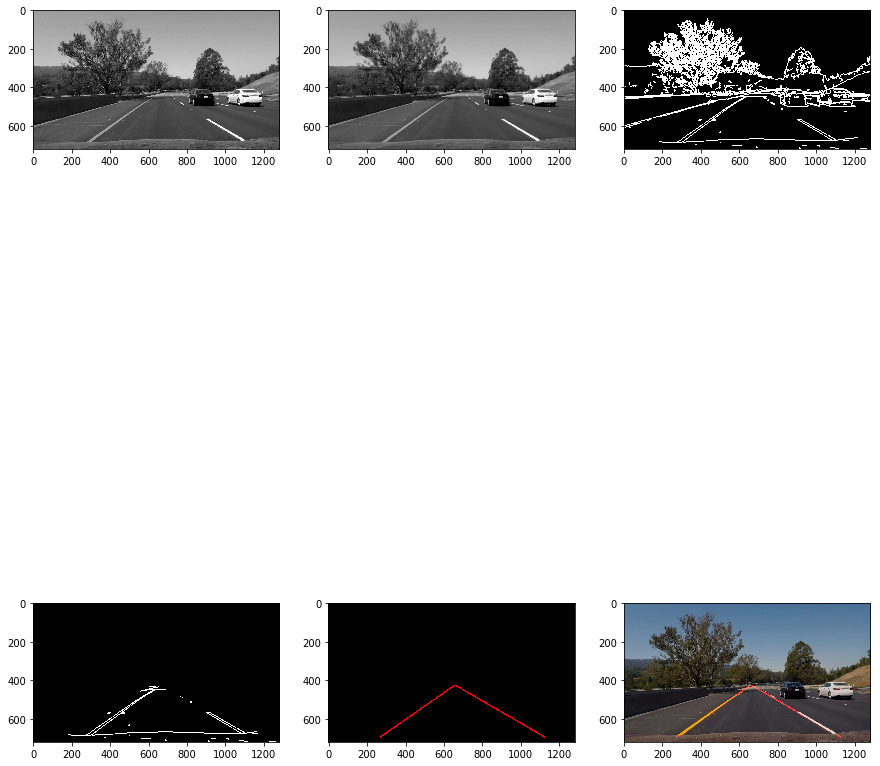

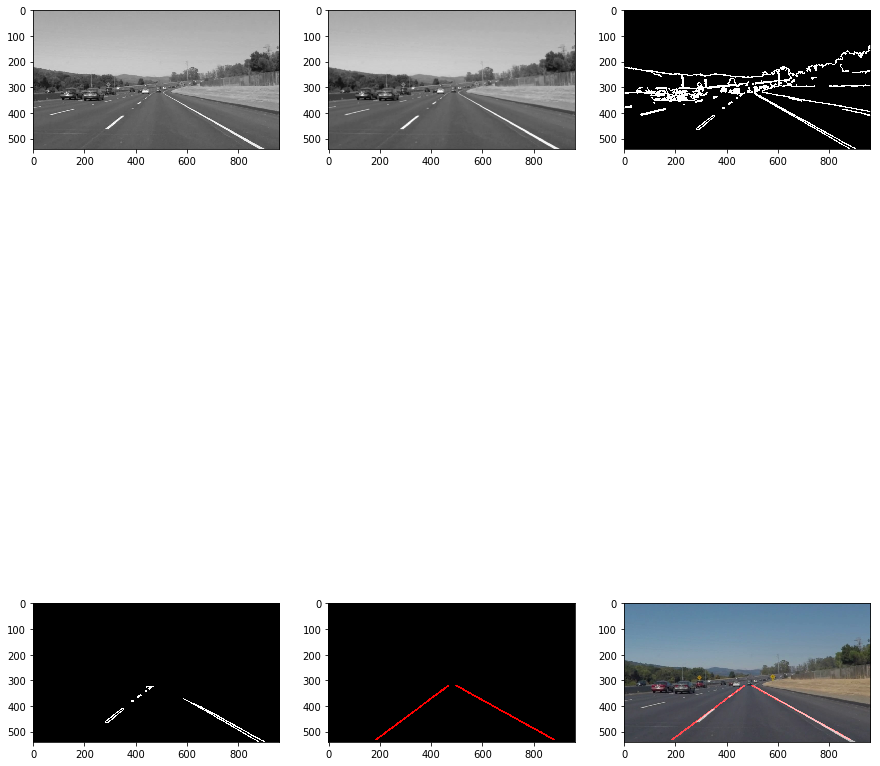

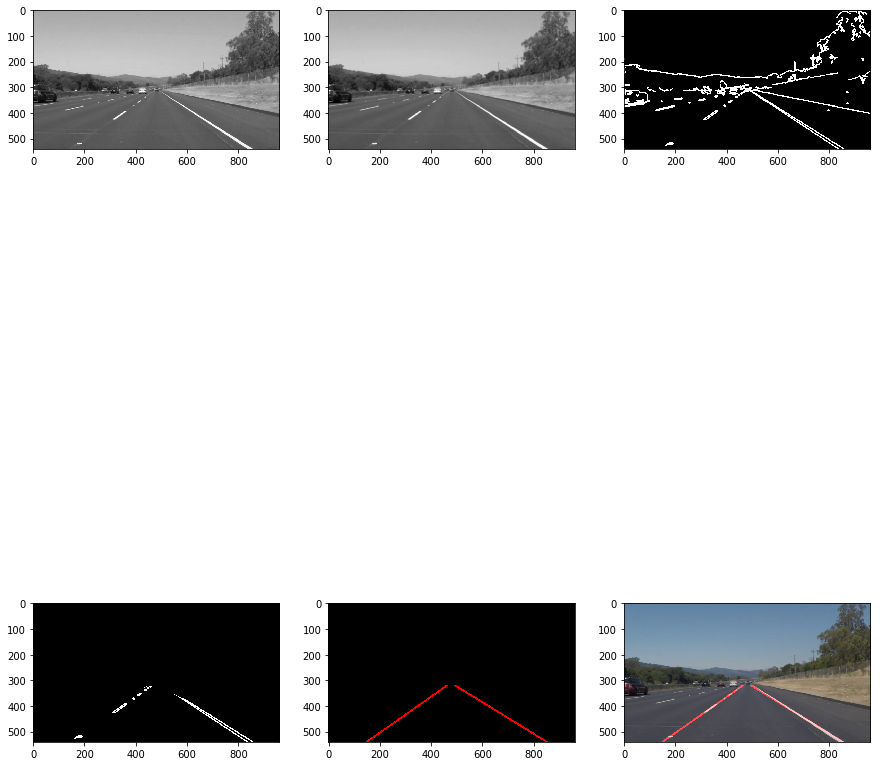

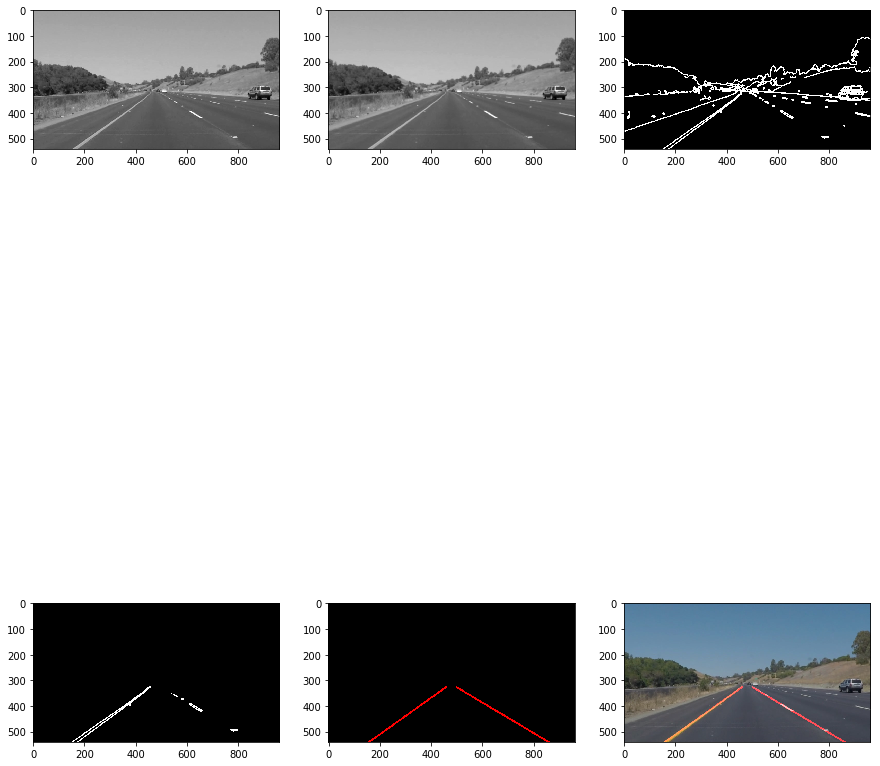

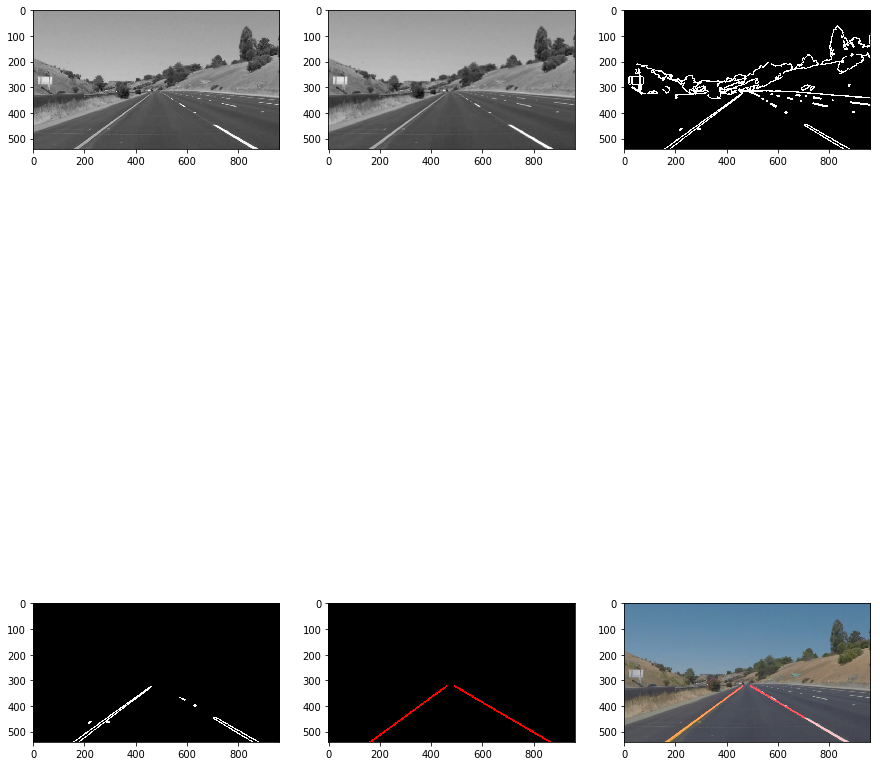

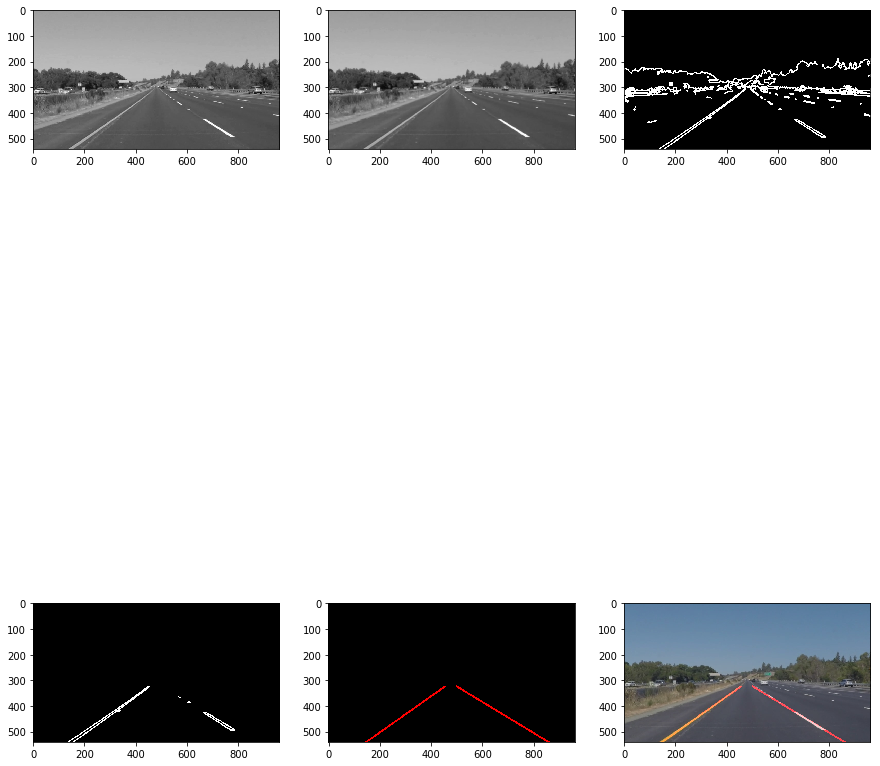

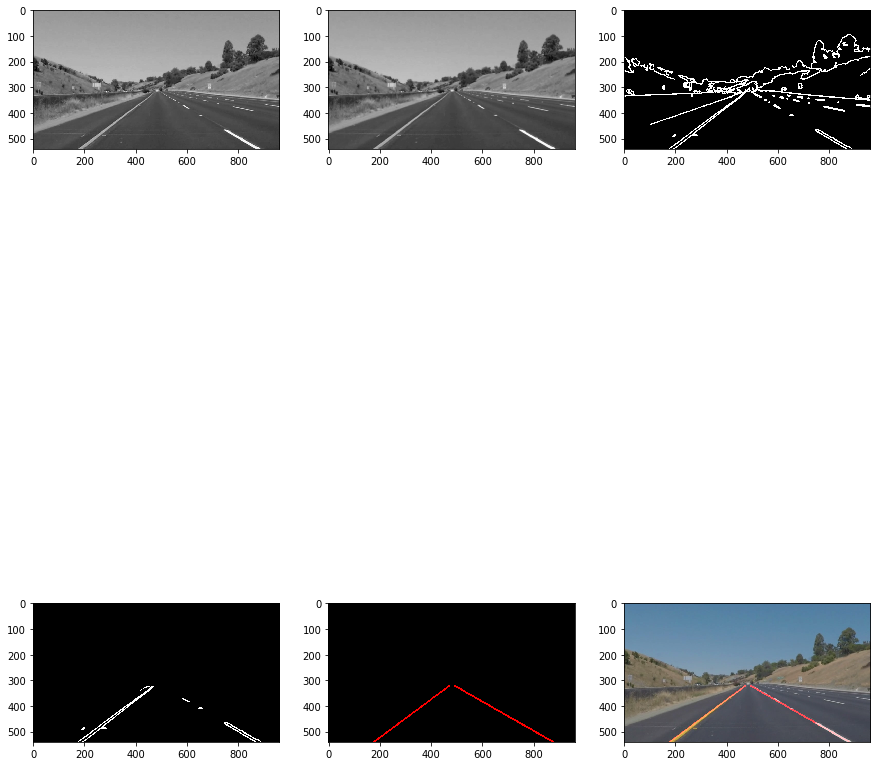

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory. 
# The images are saved in the out directory
global img_cnt

directory = "test_images/"
# create out directory for processed files
if not os.path.exists(directory + "out"):
    os.makedirs(directory + "out")

# Start of main
img_cnt = 1
# get list of input files in test dir
images_in = os.listdir(directory);
#loop thru the list and process one by one
for img_in in images_in:
    if img_in.endswith(".jpg") or img_in.endswith(".png"):
        # Read in and grayscale the current image ref by index
        image_curr = mpimg.imread(directory + img_in);
        img_with_line_edges = find_lane_lines(image_curr,"on")
        plt.imsave(directory + "out/w_line_" + img_in, img_with_line_edges)
        
        
    
        
    
    
    
    
    



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    # if debug = frames will extract frame and overlayed image. Please create /frames directory in working folder
    return find_lane_lines(image, "off")

Let's try the one with the solid white lane on the right first ...

In [10]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4



100%|█████████▉| 221/222 [00:03<00:00, 61.19it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.19 s, sys: 771 ms, total: 3.97 s
Wall time: 4.18 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [12]:
yellow_output = 'yellow.mp4'
# used for debugging individual frames
global img_cnt
img_cnt = 1
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)

%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4



100%|█████████▉| 681/682 [00:12<00:00, 56.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 10.6 s, sys: 2.52 s, total: 13.1 s
Wall time: 12.7 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

##############My Comments below################

First going thru the rubrics:

CRITERIA
MEETS SPECIFICATIONS

1. Does the pipeline for line identification take road images from a video as input and return an annotated video stream as output? The output video is an annotated version of the input video.

Guru: yes the output video is annotated. Pipleline is defined in function "find_lane_lines". It offers an optional input for debugging which I found very useful. There is some noise in the extra challenge (3nd video) and I have tried to extract the video frame and debug the problem. Surprizingly the debug based on the frame works well. Therefore I need to spend some more time tuning the parameters for the video.

2. Has a pipeline been implemented that uses the helper functions and / or other code to roughly identify the left and right lane lines with either line segments or solid lines? (example solution included in the repository output: raw-lines-example.mp4)

Guru: Yes

3. In a rough sense, the left and right lane lines are accurately annotated throughout almost all of the video. Annotations can be segmented or solid lines

Guru: Yes. There are 1-2 frames noise in yellow video but by large its fairly accurate. It is lot more in the challenge and another personal challenge based on a video I shot. Based on frame debug I am not able to re-create the issue. The frame in video works well in the image based detector

4. Have detected line segments been filtered / averaged / extrapolated to map out the full extent of the left and right lane boundaries? (example solution included in the repository: P1_example.mp4)

Guru: yes

5. Visually, the left and right lane lines are accurately annotated by solid lines throughout most of the video.

Guru: yes

Reflection

CRITERIA
MEETS SPECIFICATIONS
Has a thoughtful reflection on the project been provided in the notebook?

Reflection describes the current pipeline, identifies its potential shortcomings and suggests possible improvements. There is no minimum length. Writing in English is preferred but you may use any language.

Guru: 
This is an exciting exercise and to annotate something real (video) is cool. Great to know many techniques like canny and Hough to determine the lane markers. I am looking forward to figuring out how else we can work with real situations. Rain, snow etc will make my currently program probably worthless :)

I would like to improve the program by employing classification techniques and imcorporate more accuracy by using more accurate vertices in hough and extrapolation. Not sure if further degree polynomial will improve better looking markers

Given time, the parameters can be tweaked to further improve the annotated video for the challenge. The extra challenge video gets confused by shawdows. Love to work on this problem but I think a better aproach may be out there in the next modules. Therefore holding off.

My own personal challenge video has noise as well. Its bascially getting confused because of puddles (lots of rain). I tried to debug the noise by extracting individual frames from the video and working on the problematic ones. Surprizingly the pipeline works well on these frames. I am guessing the clip2.fl_image(process_image) is introducing some noise which is confusing the detectors.





## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
global img_cnt
img_cnt = 1
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4



  6%|▌         | 14/251 [00:00<00:05, 41.10it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
p_challenge_output = 'extra2.mp4'
clip2 = VideoFileClip('personal_chg.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(p_challenge_output, audio=False)